## 3. Cluster_DatosFull

### Objetivo

Generar cluster's de estaciones en base a todas las variables: demanda, geográficas y demográficas

### Descripción General de notebook

    1. Carga de datos base proveniente de etapa de preparación
    2. Reducción de dimensionalidad PCA
    3. Selección de valor k óptimo utilizando Elbow y Silhouette
    4. Clusterización final en base a k

## 1. Carga de datos de entrada

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

%matplotlib inline

pd.set_option('display.max_rows', 5)

In [6]:
df_FinalCluster_Original = pd.read_csv('../../data/df_FinalCluster_2017_2019.csv',
                              dtype={'Distrito':'category','Plazas':'category','Barrio':'category'})

df_FinalCluster_Original.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ESTACION             172 non-null    int64   
 1   DEMANDA_RATIO        172 non-null    float64 
 2   DMNDA_201703         172 non-null    float64 
 3   DMNDA_201704         172 non-null    float64 
 4   DMNDA_201705         172 non-null    int64   
 5   DMNDA_201706         172 non-null    int64   
 6   DMNDA_201707         172 non-null    int64   
 7   DMNDA_201708         172 non-null    int64   
 8   DMNDA_201709         172 non-null    int64   
 9   DMNDA_201710         172 non-null    int64   
 10  DMNDA_201711         172 non-null    int64   
 11  DMNDA_201712         172 non-null    float64 
 12  DMNDA_201801         172 non-null    float64 
 13  DMNDA_201802         172 non-null    int64   
 14  DMNDA_201803         172 non-null    int64   
 15  DMNDA_201804         17

In [7]:
# Creación de DF de trabajo: df_FinalCluster. Se elimina 'ESTACION' y se identifican las variables categóricas y numéricas

df_FinalCluster = df_FinalCluster_Original.copy()

df_FinalCluster = df_FinalCluster.drop(columns='ESTACION')
df_FinalCluster.info()

num_cols = list(df_FinalCluster._get_numeric_data().columns)
cat_cols = list(set(df_FinalCluster.columns) - set(num_cols))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   DEMANDA_RATIO        172 non-null    float64 
 1   DMNDA_201703         172 non-null    float64 
 2   DMNDA_201704         172 non-null    float64 
 3   DMNDA_201705         172 non-null    int64   
 4   DMNDA_201706         172 non-null    int64   
 5   DMNDA_201707         172 non-null    int64   
 6   DMNDA_201708         172 non-null    int64   
 7   DMNDA_201709         172 non-null    int64   
 8   DMNDA_201710         172 non-null    int64   
 9   DMNDA_201711         172 non-null    int64   
 10  DMNDA_201712         172 non-null    float64 
 11  DMNDA_201801         172 non-null    float64 
 12  DMNDA_201802         172 non-null    int64   
 13  DMNDA_201803         172 non-null    int64   
 14  DMNDA_201804         172 non-null    int64   
 15  DMNDA_201805         17

In [8]:
print(num_cols)
print(cat_cols)

['DEMANDA_RATIO', 'DMNDA_201703', 'DMNDA_201704', 'DMNDA_201705', 'DMNDA_201706', 'DMNDA_201707', 'DMNDA_201708', 'DMNDA_201709', 'DMNDA_201710', 'DMNDA_201711', 'DMNDA_201712', 'DMNDA_201801', 'DMNDA_201802', 'DMNDA_201803', 'DMNDA_201804', 'DMNDA_201805', 'DMNDA_201806', 'DMNDA_201807', 'DMNDA_201808', 'DMNDA_201809', 'DMNDA_201810', 'DMNDA_201811', 'DMNDA_201812', 'DMNDA_201901', 'DMNDA_201902', 'DMNDA_201903', 'DMNDA_201904', 'DMNDA_201905', 'DMNDA_201906', 'DMNDA_201907', 'DMNDA_201908', 'DMNDA_201909', 'DMNDA_201910', 'DMNDA_201911', 'DMNDA_201912', 'Gis_X', 'Gis_Y', 'Longitud', 'Latitud', 'Tasa_Paro', 'Renta_Media_Persona', 'Renta_Media_Hogar', 'Poblacion']
['Barrio', 'Distrito', 'Plazas']


## 2. Reducción de dimensionalidad PCA

### Transformando categóricas: One Hot Encoder (variables dummies)

In [14]:
df_cat = df_FinalCluster[cat_cols]
df_cat

,Plazas,Barrio,Distrito
0,30,01-06,1
1,30,01-06,1
...,...,...,...
170,24,05-01,5
171,24,02-01,2


In [15]:
OneHot = OneHotEncoder(handle_unknown='ignore', drop='first')
OneHot.fit(df_cat.values)

df_cat_OneHot = OneHot.transform(df_cat.values).toarray()
df_cat_OneHot.shape

(172, 48)

### Concatenación de DF: Numéricos y Categóricas

In [16]:
df_knn_final = pd.concat([df_FinalCluster[num_cols], pd.DataFrame(df_cat_OneHot)], axis=1)
df_knn_final.columns = df_knn_final.columns.astype(str)
df_knn_final.info()
df_knn_final

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 91 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DEMANDA_RATIO        172 non-null    float64
 1   DMNDA_201703         172 non-null    float64
 2   DMNDA_201704         172 non-null    float64
 3   DMNDA_201705         172 non-null    int64  
 4   DMNDA_201706         172 non-null    int64  
 5   DMNDA_201707         172 non-null    int64  
 6   DMNDA_201708         172 non-null    int64  
 7   DMNDA_201709         172 non-null    int64  
 8   DMNDA_201710         172 non-null    int64  
 9   DMNDA_201711         172 non-null    int64  
 10  DMNDA_201712         172 non-null    float64
 11  DMNDA_201801         172 non-null    float64
 12  DMNDA_201802         172 non-null    int64  
 13  DMNDA_201803         172 non-null    int64  
 14  DMNDA_201804         172 non-null    int64  
 15  DMNDA_201805         172 non-null    flo

,DEMANDA_RATIO,DMNDA_201703,DMNDA_201704,DMNDA_201705,DMNDA_201706,DMNDA_201707,DMNDA_201708,DMNDA_201709,DMNDA_201710,DMNDA_201711,...,38,39,40,41,42,43,44,45,46,47
0,2505.333333,7.0,2212.0,2942,2946,3229,2929,3685,3606,2879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1313.468750,3.0,1174.0,1579,1536,1597,1491,1924,2033,1543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,824.400000,0.0,845.0,1046,1162,856,647,1190,1230,981,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
171,3708.705882,0.0,0.0,924,3272,2328,2791,3878,3973,3470,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reducción de dimensionalidad PCA

In [17]:
df_pca_2 = PCA(n_components=2).fit_transform(df_knn_final)
df_pca_3 = PCA(n_components=3).fit_transform(df_knn_final)
df_pca_4 = PCA(n_components=4).fit_transform(df_knn_final)
df_pca_5 = PCA(n_components=5).fit_transform(df_knn_final)


## 3. Selección de valor k óptimo utilizando Elbow y Silhouette

### Usando df_pca_2

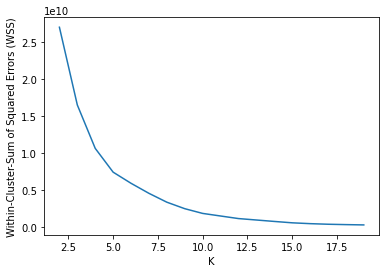

In [19]:
# ELBOW

K=range(2,20)
wss = []

for k in K:
    kmeans=cluster.KMeans(
               n_clusters=k,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,)
    kmeans=kmeans.fit(df_pca_2)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
plt.xlabel('K')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.plot(K,wss)

In [20]:
# SILHOUETTE
K=range(2,20)
for k in K:
    labels=KMeans(
               n_clusters=k,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=200,).fit(df_pca_2).labels_
    print ("Silhouette score for k(clusters) = "+str(k)+" is "+str(metrics.silhouette_score(df_pca_2,labels,metric="euclidean",sample_size=1000,random_state=200)))

Silhouette score for k(clusters) = 2 is 0.5819000115426455
Silhouette score for k(clusters) = 3 is 0.5087702603216924
Silhouette score for k(clusters) = 4 is 0.5418873611469094
Silhouette score for k(clusters) = 5 is 0.5720700653624665
Silhouette score for k(clusters) = 6 is 0.564216310190777
Silhouette score for k(clusters) = 7 is 0.5759096418838109
Silhouette score for k(clusters) = 8 is 0.6220079388153364
Silhouette score for k(clusters) = 9 is 0.6497523634280833
Silhouette score for k(clusters) = 10 is 0.7016660977986101
Silhouette score for k(clusters) = 11 is 0.7141848771323434
Silhouette score for k(clusters) = 12 is 0.7417633323253218
Silhouette score for k(clusters) = 13 is 0.748313329172286
Silhouette score for k(clusters) = 14 is 0.7745309929370625
Silhouette score for k(clusters) = 15 is 0.7929906271854311
Silhouette score for k(clusters) = 16 is 0.8088038574712738
Silhouette score for k(clusters) = 17 is 0.8056719187009507
Silhouette score for k(clusters) = 18 is 0.8195191

### Usando df_pca_3

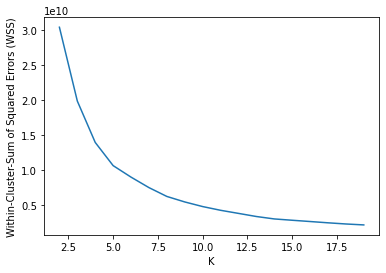

In [21]:
K=range(2,20)
wss = []

for k in K:
    kmeans=cluster.KMeans(
               n_clusters=k,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,)
    kmeans=kmeans.fit(df_pca_3)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
plt.xlabel('K')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.plot(K,wss)

In [22]:
# SILHOUETTE
K=range(2,20)
for k in K:
    labels=KMeans(
               n_clusters=k,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=200,).fit(df_pca_3).labels_
    print ("Silhouette score for k(clusters) = "+str(k)+" is "+str(metrics.silhouette_score(df_pca_3,labels,metric="euclidean",sample_size=1000,random_state=200)))

Silhouette score for k(clusters) = 2 is 0.544607558652762
Silhouette score for k(clusters) = 3 is 0.4551158397548832
Silhouette score for k(clusters) = 4 is 0.4727564093770293
Silhouette score for k(clusters) = 5 is 0.4806809988418523
Silhouette score for k(clusters) = 6 is 0.4509860874111724
Silhouette score for k(clusters) = 7 is 0.4385305504527851
Silhouette score for k(clusters) = 8 is 0.47255977718725206
Silhouette score for k(clusters) = 9 is 0.4759614763405701
Silhouette score for k(clusters) = 10 is 0.49497630700286643
Silhouette score for k(clusters) = 11 is 0.49985860216249695
Silhouette score for k(clusters) = 12 is 0.5201792693735
Silhouette score for k(clusters) = 13 is 0.513743150121675
Silhouette score for k(clusters) = 14 is 0.5254364306577445
Silhouette score for k(clusters) = 15 is 0.5261720767554057
Silhouette score for k(clusters) = 16 is 0.49838628043103267
Silhouette score for k(clusters) = 17 is 0.5083741361730217
Silhouette score for k(clusters) = 18 is 0.512560

### Usando df_pca_4

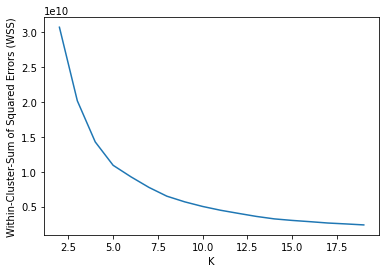

In [23]:
K=range(2,20)
wss = []

for k in K:
    kmeans=cluster.KMeans(
               n_clusters=k,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,)
    kmeans=kmeans.fit(df_pca_4)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
plt.xlabel('K')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.plot(K,wss)

In [24]:
# SILHOUETTE
K=range(2,20)
for k in K:
    labels=KMeans(
               n_clusters=k,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=200,).fit(df_pca_4).labels_
    print ("Silhouette score for k(clusters) = "+str(k)+" is "+str(metrics.silhouette_score(df_pca_4,labels,metric="euclidean",sample_size=1000,random_state=200)))

Silhouette score for k(clusters) = 2 is 0.5412581555021893
Silhouette score for k(clusters) = 3 is 0.4506479565615669
Silhouette score for k(clusters) = 4 is 0.4676405933704666
Silhouette score for k(clusters) = 5 is 0.4743286983981859
Silhouette score for k(clusters) = 6 is 0.4418631197593769
Silhouette score for k(clusters) = 7 is 0.42966859324083784
Silhouette score for k(clusters) = 8 is 0.4603512652512421
Silhouette score for k(clusters) = 9 is 0.4638065643459455
Silhouette score for k(clusters) = 10 is 0.4824649638797983
Silhouette score for k(clusters) = 11 is 0.48625536298940836
Silhouette score for k(clusters) = 12 is 0.5055303635951681
Silhouette score for k(clusters) = 13 is 0.505637412350974
Silhouette score for k(clusters) = 14 is 0.5094451137190673
Silhouette score for k(clusters) = 15 is 0.5210755966542967
Silhouette score for k(clusters) = 16 is 0.48038081235993096
Silhouette score for k(clusters) = 17 is 0.49010587009335604
Silhouette score for k(clusters) = 18 is 0.49

### Usando df_pca_5

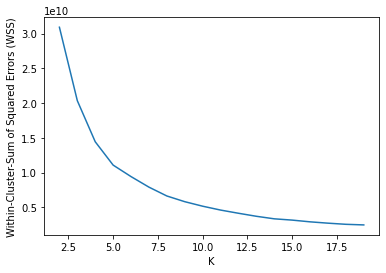

In [25]:
K=range(2,20)
wss = []

for k in K:
    kmeans=cluster.KMeans(
               n_clusters=k,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,)
    kmeans=kmeans.fit(df_pca_5)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)
    
plt.xlabel('K')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.plot(K,wss)

In [26]:
# SILHOUETTE
K=range(2,20)
for k in K:
    labels=KMeans(
               n_clusters=k,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=200,).fit(df_pca_5).labels_
    print ("Silhouette score for k(clusters) = "+str(k)+" is "+str(metrics.silhouette_score(df_pca_5,labels,metric="euclidean",sample_size=1000,random_state=200)))

Silhouette score for k(clusters) = 2 is 0.5395598189854319
Silhouette score for k(clusters) = 3 is 0.44873165393568354
Silhouette score for k(clusters) = 4 is 0.4652760220119488
Silhouette score for k(clusters) = 5 is 0.4708452727498259
Silhouette score for k(clusters) = 6 is 0.43828929272490297
Silhouette score for k(clusters) = 7 is 0.42401859601468633
Silhouette score for k(clusters) = 8 is 0.45453518854096225
Silhouette score for k(clusters) = 9 is 0.457523867113649
Silhouette score for k(clusters) = 10 is 0.47497854144648477
Silhouette score for k(clusters) = 11 is 0.47868135946258256
Silhouette score for k(clusters) = 12 is 0.4966085525108153
Silhouette score for k(clusters) = 13 is 0.49798493527103055
Silhouette score for k(clusters) = 14 is 0.50643073097497
Silhouette score for k(clusters) = 15 is 0.5093557514342005
Silhouette score for k(clusters) = 16 is 0.5134143909632152
Silhouette score for k(clusters) = 17 is 0.5032422865948785
Silhouette score for k(clusters) = 18 is 0.4

#### CONCLUSIÓN: se determina que para todos los casos analizados, el mejor valor para la cantidad de cluster a trabajar es k=5

## 4. Clusterización final en base a k=5

La clusterización se ejecuta para cada DataFrame según PCA siempre considerando k=5. 
La ejecución del algoritmo final considera:

    - Estandarización: MinMaxScaler()
    - Clusterización: KMeans según parámetros observados en siguiente celda

#### Preparación de algoritmo

In [27]:
n_cluster = 5

scaler = MinMaxScaler()
kmeans = KMeans(
               n_clusters=n_cluster,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=200,)

pipeline = make_pipeline(scaler, kmeans)
pipeline

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kmeans',
                 KMeans(max_iter=500, n_clusters=5, n_init=50,
                        random_state=200))])

#### Predicción de cluster final

In [28]:
df_pred_pca2_t = pipeline.fit_transform(df_pca_2)
df_pred_pca2 = pipeline.fit_predict(df_pca_2)
df_pred_pca3 = pipeline.fit_predict(df_pca_3)
df_pred_pca4 = pipeline.fit_predict(df_pca_4)
df_pred_pca5 = pipeline.fit_predict(df_pca_5)


In [29]:
df_pred_pca2_t

array([[0.08769896, 0.44519282, 0.72932007, 0.83334219, 0.78701994],
       [0.08439111, 0.44687306, 0.73052639, 0.82996538, 0.79189311],
       [0.59736317, 0.27872437, 0.31531239, 0.75198389, 0.16080128],
       [0.46147098, 0.08161943, 0.20490619, 0.52133416, 0.39621912],
       [0.59560953, 0.27520271, 0.31119407, 0.74758125, 0.16347559],
       [0.33095232, 0.09992601, 0.33381419, 0.49621889, 0.53435935],
       [0.32964832, 0.10628773, 0.33665888, 0.49206336, 0.5405355 ],
       [0.33000066, 0.10490092, 0.33596281, 0.49289063, 0.53917935],
       [0.66736911, 0.40783659, 0.30163653, 0.17031887, 0.6884813 ],
       [0.37219218, 0.09972671, 0.34637072, 0.65191491, 0.39135044],
       [0.59652873, 0.27671915, 0.31268647, 0.74928102, 0.16222272],
       [0.60044863, 0.28205577, 0.31680834, 0.75444709, 0.15749997],
       [0.55202533, 0.20902974, 0.13626911, 0.39097663, 0.47747397],
       [0.59533487, 0.27548856, 0.31224263, 0.74844261, 0.16347584],
       [0.59713728, 0.27813028, 0.

In [30]:
df_pred_pca2

array([0, 0, 4, 1, 4, 1, 1, 1, 3, 1, 4, 4, 2, 4, 4, 4, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4,
       4, 4, 1, 4, 1, 4, 3, 1, 1, 0, 3, 3, 3, 2, 2, 0, 3, 3, 3, 3, 3, 3,
       3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 0, 1, 0, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 0, 2, 1, 1, 2, 3, 3, 2, 2, 2, 3, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 3, 3, 3, 2, 3, 3, 1, 2, 0, 3, 2, 3, 1, 2,
       2, 3, 2, 3, 2, 3, 3, 3, 1, 1, 0, 0, 2, 3, 2, 2, 2, 3, 2, 3, 3, 2,
       3, 0, 2, 2, 4, 1, 2, 3, 2, 4, 3, 1, 3, 2, 2, 2, 3, 1])

In [31]:
df_pred_pca3

array([4, 4, 3, 2, 3, 0, 2, 2, 0, 2, 3, 3, 2, 3, 3, 3, 0, 2, 2, 2, 4, 0,
       2, 4, 0, 4, 4, 4, 0, 2, 0, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 0, 3, 0, 2, 2, 4, 1, 1, 1, 2, 3, 4, 1, 0, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 4, 2, 4, 2, 2, 2, 2, 2, 2, 0, 0,
       2, 0, 3, 0, 2, 3, 1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2,
       2, 2, 4, 4, 4, 4, 4, 2, 1, 1, 1, 0, 1, 1, 2, 2, 4, 1, 3, 1, 2, 3,
       3, 1, 0, 1, 2, 1, 1, 1, 2, 2, 4, 4, 2, 1, 1, 3, 2, 1, 2, 1, 1, 1,
       1, 4, 2, 1, 3, 2, 3, 1, 2, 3, 1, 2, 1, 3, 2, 2, 1, 0])

In [32]:
df_pred_pca4

array([2, 2, 1, 1, 1, 0, 1, 0, 3, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0,
       1, 2, 0, 2, 2, 2, 0, 1, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 0, 0, 1, 3, 1, 1, 2, 3, 3, 3, 3, 4, 2, 3, 3, 3, 3, 3, 3,
       3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 0, 2, 1, 1, 1, 1, 1, 4, 4, 4,
       0, 0, 4, 4, 4, 1, 3, 3, 1, 0, 1, 3, 0, 0, 0, 3, 0, 0, 0, 0, 1, 1,
       1, 1, 2, 2, 2, 2, 0, 1, 3, 3, 3, 4, 3, 3, 1, 1, 2, 3, 4, 3, 1, 1,
       1, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 2, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1,
       3, 2, 1, 1, 1, 4, 1, 3, 1, 1, 3, 4, 3, 1, 3, 1, 3, 0])

In [33]:
df_pred_pca5

array([4, 4, 0, 0, 0, 1, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 4, 1,
       0, 4, 1, 4, 4, 4, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 1, 1, 0, 2, 0, 0, 4, 2, 2, 2, 2, 3, 4, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 4, 1, 4, 0, 0, 0, 0, 0, 3, 3, 3,
       1, 1, 3, 3, 3, 0, 2, 2, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0,
       0, 1, 4, 1, 4, 4, 1, 0, 2, 2, 2, 3, 2, 2, 0, 0, 4, 2, 3, 2, 0, 0,
       0, 2, 1, 2, 0, 2, 2, 2, 0, 0, 4, 4, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0,
       2, 4, 0, 0, 0, 3, 0, 2, 0, 0, 2, 3, 2, 0, 2, 0, 2, 1])

#### En base a lo observado y a las decisiones tomadas en este proyecto, el dataframe final a utilizar corresponde a PCA=3

El identificador de cluster para cada una de las estaciones se concatena con los valores originales y se exporta al CSV definitivo

In [34]:
df_final_Clusterizado = pd.concat([df_FinalCluster_Original, pd.DataFrame(df_pred_pca3)], axis=1)

df_final_Clusterizado.rename(columns={0: 'CLUSTER'}, inplace=True)
df_final_Clusterizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ESTACION             172 non-null    int64   
 1   DEMANDA_RATIO        172 non-null    float64 
 2   DMNDA_201703         172 non-null    float64 
 3   DMNDA_201704         172 non-null    float64 
 4   DMNDA_201705         172 non-null    int64   
 5   DMNDA_201706         172 non-null    int64   
 6   DMNDA_201707         172 non-null    int64   
 7   DMNDA_201708         172 non-null    int64   
 8   DMNDA_201709         172 non-null    int64   
 9   DMNDA_201710         172 non-null    int64   
 10  DMNDA_201711         172 non-null    int64   
 11  DMNDA_201712         172 non-null    float64 
 12  DMNDA_201801         172 non-null    float64 
 13  DMNDA_201802         172 non-null    int64   
 14  DMNDA_201803         172 non-null    int64   
 15  DMNDA_201804         17

In [35]:
df_final_Clusterizado[['ESTACION', 'CLUSTER']].to_csv('../../data/Clusterizada_DataFull.csv', index=False)

In [36]:
df_final_Clusterizado[['ESTACION', 'CLUSTER']]

,ESTACION,CLUSTER
0,1,4
1,2,4
...,...,...
170,146,1
171,175,0
